# Ma Mbaye Diop expert en traitement d'image (AMU)**

# **Projet : Traitement d'image medical **

In [191]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [193]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

train_path = glob("/content/drive/MyDrive/data_organe/train/*")
valid_path = glob("/content/drive/MyDrive/data_organe/val/*")

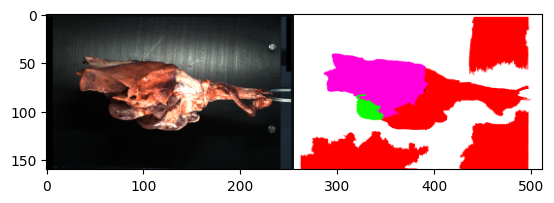

In [194]:
chemin = plt.imread('/content/drive/MyDrive/image_fusion1.png')
plt.imshow(chemin)

Taille de l'image: (160, 512, 4)


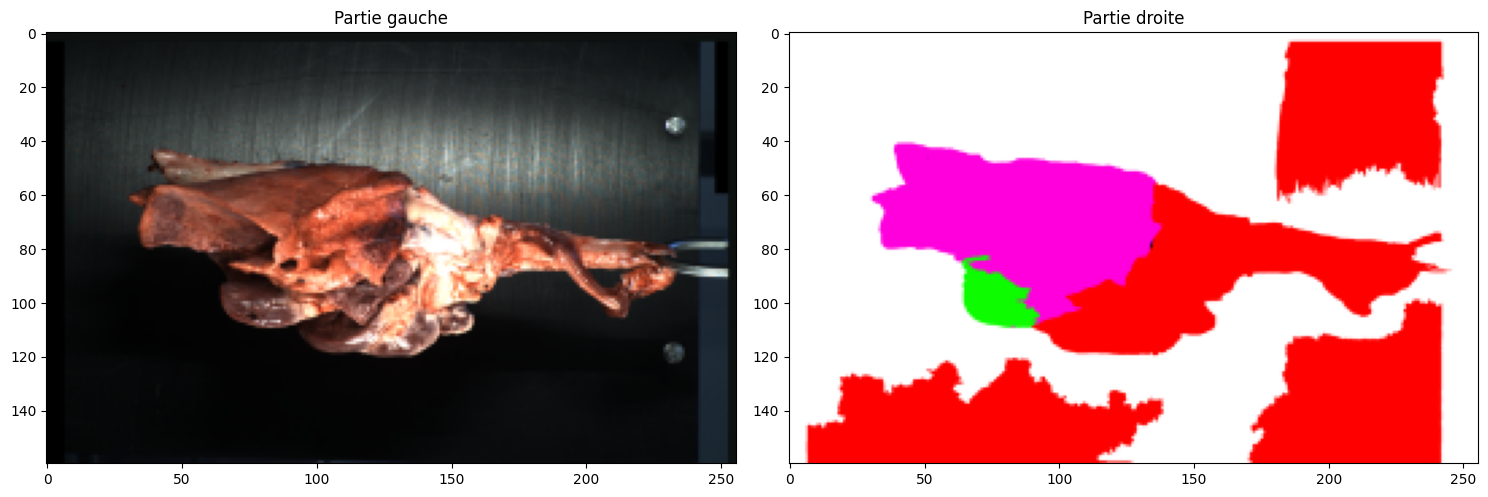

In [195]:
import matplotlib.pyplot as plt

# Charger l'image
img = plt.imread('/content/drive/MyDrive/image_fusion1.png')
print(f"Taille de l'image: {img.shape}")  # Affiche la taille de l'image

# Créer une figure avec une ligne et deux colonnes
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Afficher les deux parties de l'image
ax[0].imshow(img[:, :256])  # Partie gauche
ax[0].set_title("Partie gauche")

ax[1].imshow(img[:, 256:])  # Partie droite
ax[1].set_title("Partie droite")

# Ajuster l'affichage
plt.tight_layout()
plt.show()

Nombre d'images trouvées : 40


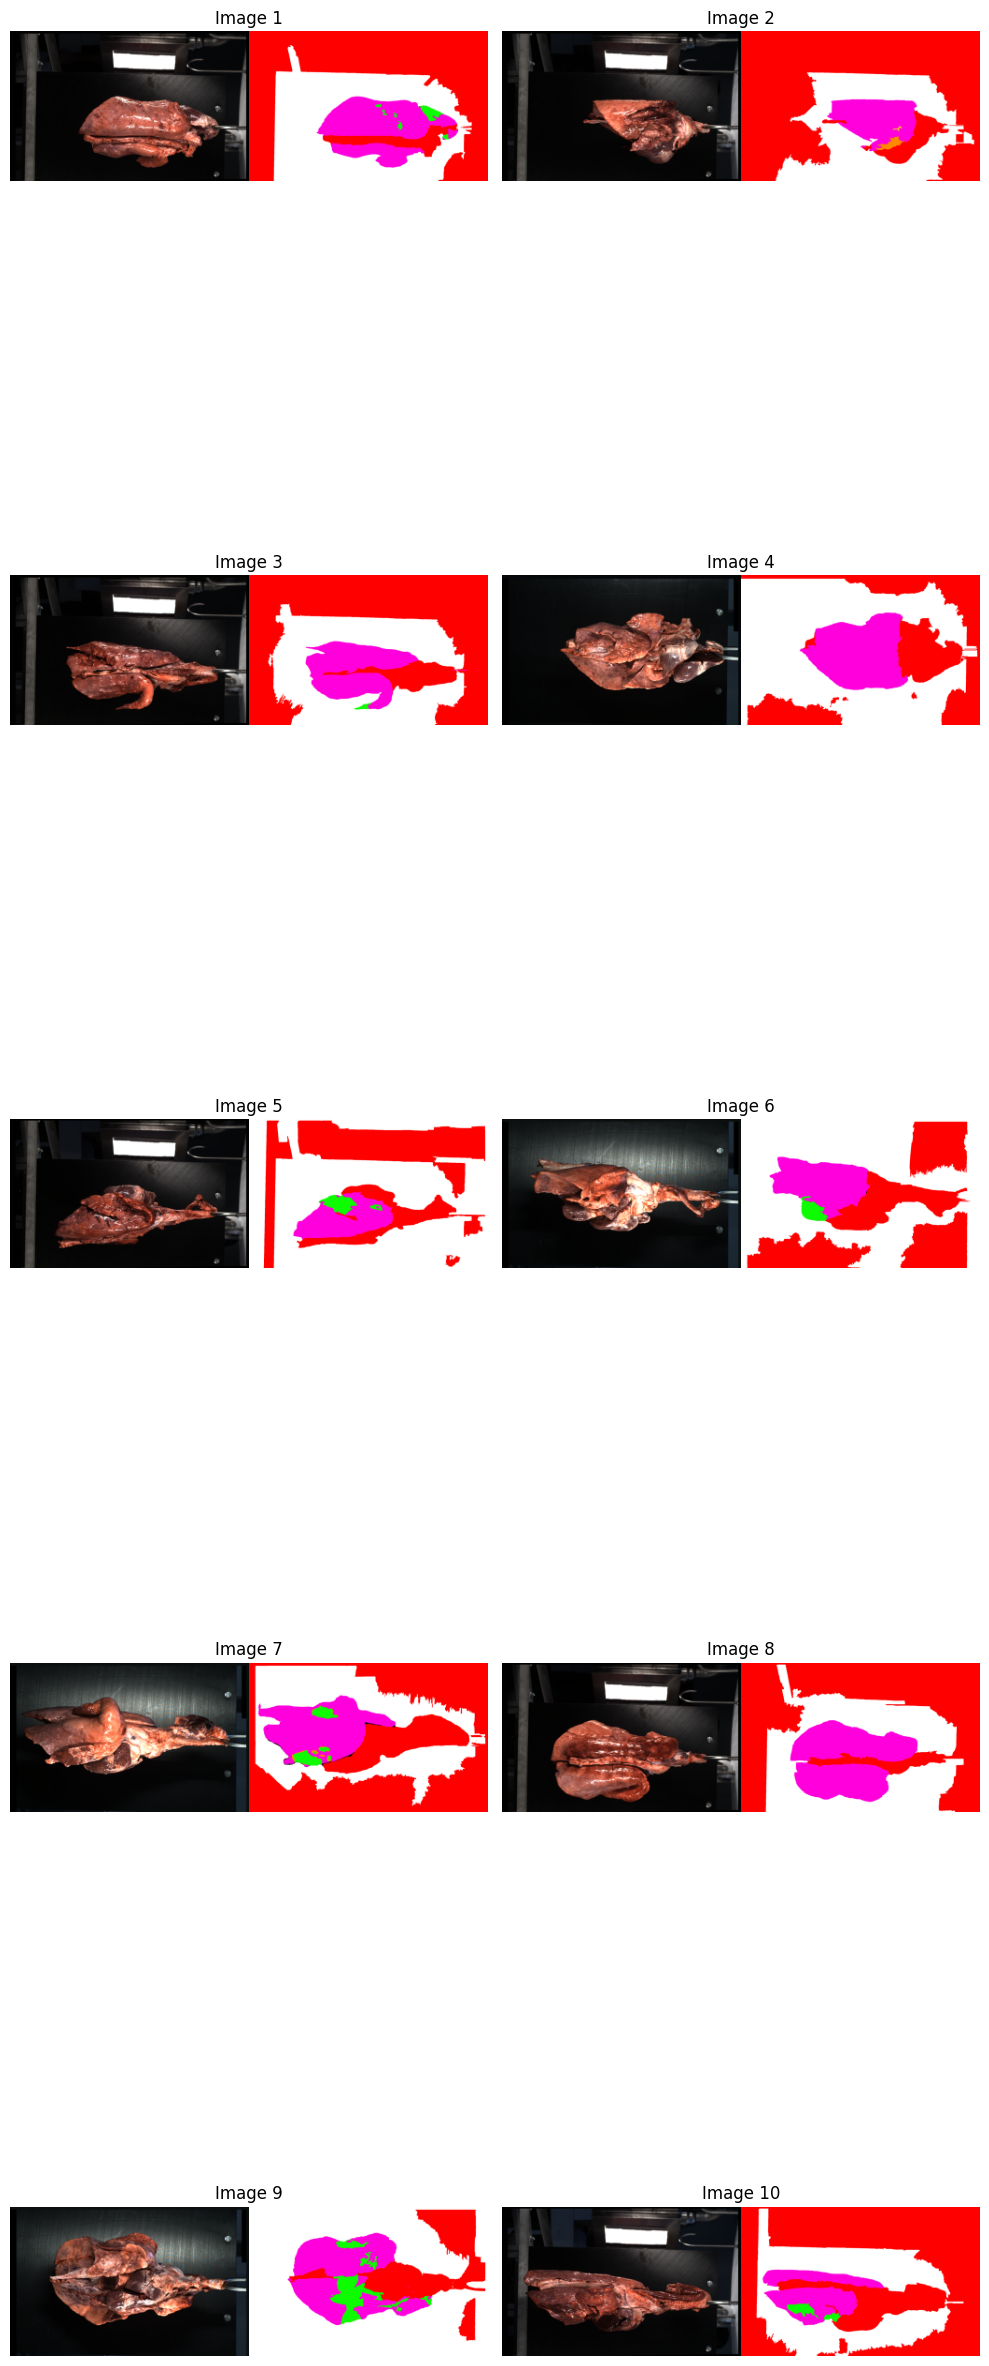

In [196]:
import glob
import matplotlib.pyplot as plt

# Chemin du dossier contenant les images
image_paths = glob.glob('/content/drive/MyDrive/data_organe/train/*')

# Vérifiez le nombre d'images trouvées
print(f"Nombre d'images trouvées : {len(image_paths)}")

# Créez un subplot et affichez les images
fig, ax = plt.subplots(5, 2, figsize=(10, 30))  # 5 lignes, 2 colonnes

# Affichez les 10 premières images
for i in range(10):  # 5 lignes * 2 colonnes = 10 images
    img = plt.imread(image_paths[i])  # Lire chaque image
    ax[i // 2, i % 2].imshow(img)  # Afficher l'image sur la grille
    ax[i // 2, i % 2].axis('off')  # Masquer les axes
    ax[i // 2, i % 2].set_title(f"Image {i+1}")  # Ajouter un titre

plt.tight_layout()
plt.show()



In [197]:
from PIL import Image

def process_image(image):
    # Convertir l'image en RGB (si l'image a 4 canaux, cela supprime le canal alpha)
    if image.shape[-1] == 4:  # Si l'image a 4 canaux (RGBA)
        image = image[:, :, :3]  # Prendre seulement les 3 premiers canaux (RGB)
    return image

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform_img=None, transform_label=None):
        self.image_paths = image_paths
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Charger l'image en utilisant PIL ou plt
        img = plt.imread(img_path)

        # Appliquer le traitement pour supprimer le canal alpha si présent
        img = process_image(img)

        # Diviser l'image en image et label (selon votre logique)
        image, label = img[:, :img.shape[1] // 2], img[:, img.shape[1] // 2:]

        # Appliquer les transformations si spécifiées
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_label:
            label = self.transform_label(label)

        return image, label


In [198]:
train_dataset = []
valid_dataset = []

In [199]:


myTransformImage = transform.Compose([
    transform.ToTensor(),
#     transform.RandomHorizontalFlip(p = 0.9)
])

myTransformLabel = transform.Compose([
    transform.ToTensor(),

])



In [200]:
train_dataset = Dataset(train_path, myTransformImage, myTransformLabel)
valid_dataset = Dataset(valid_path, myTransformImage, myTransformLabel)


# Batches

batch_size = 5
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, 1, shuffle = True)


In [201]:
def show_batch(whole_batch):
    images, label = whole_batch[0], whole_batch[1]
    images = images.numpy()
    label = label.numpy()
    fig, lab = plt.subplots(5, 2, figsize = (10, 30))

    for i in range(5):
        lab[i][0].imshow(np.transpose(images[i], (1,2,0)))
        lab[i][1].imshow(np.transpose(label[i], (1,2,0)))



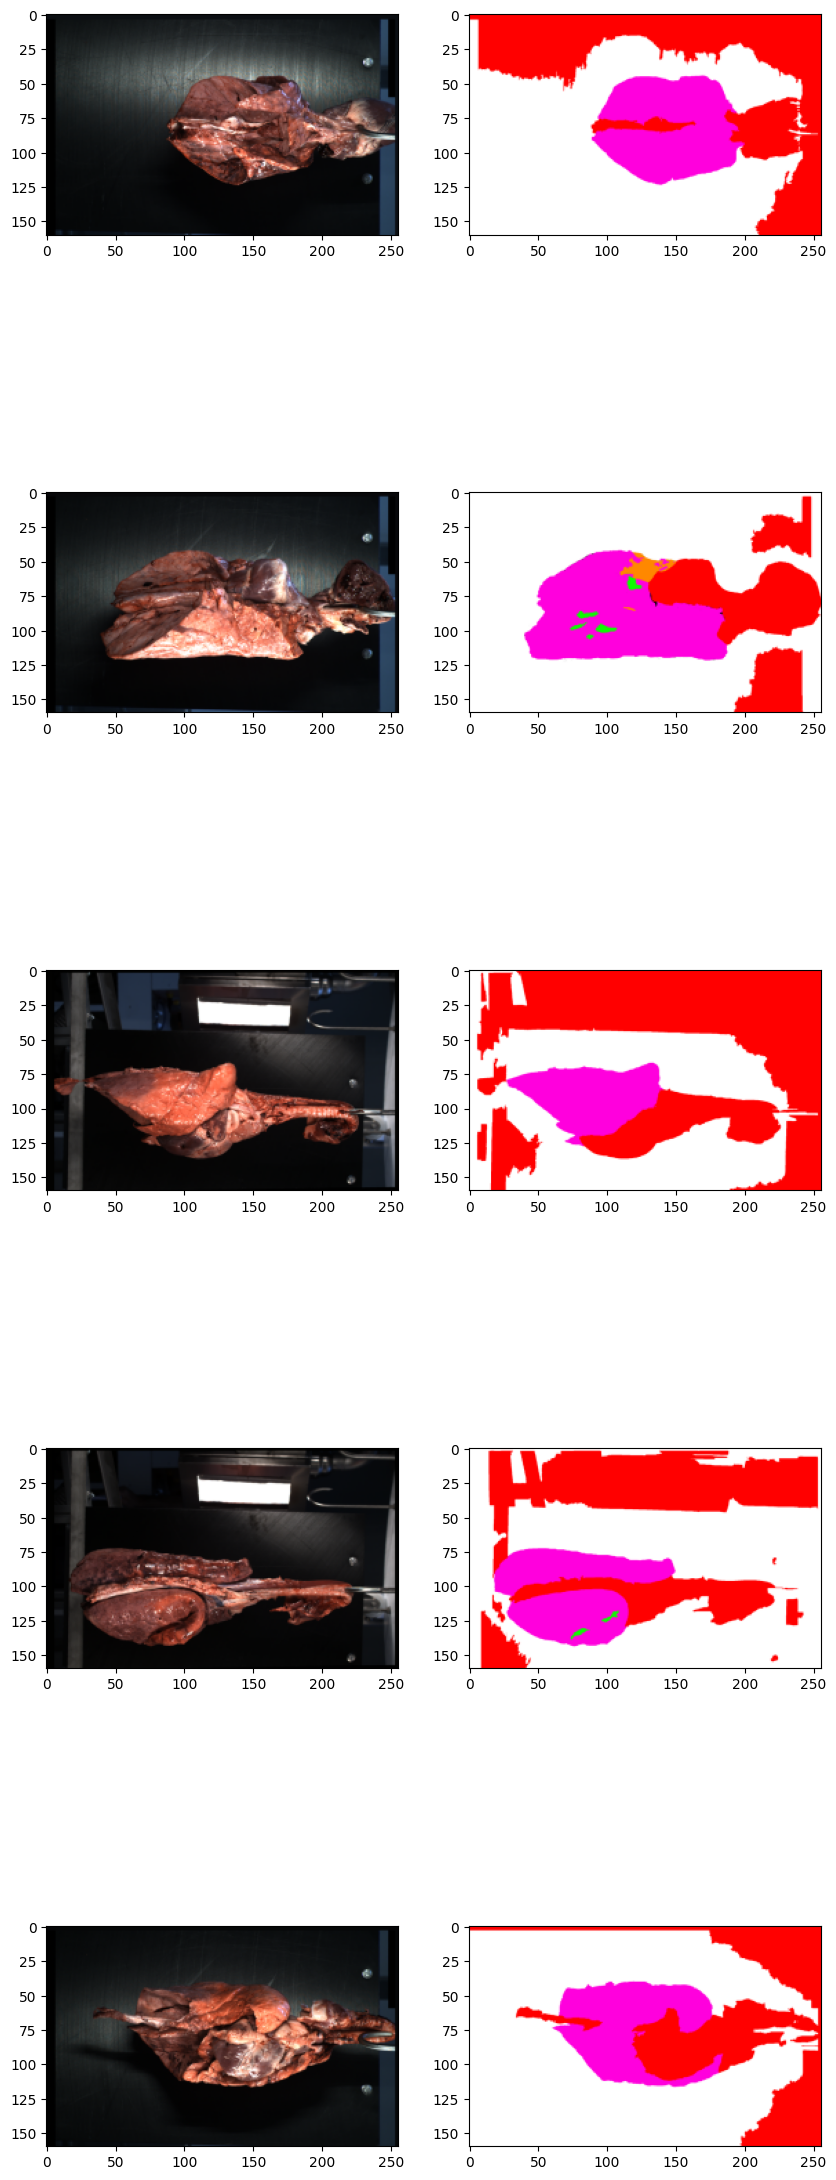

In [202]:
data_iter = iter(train_loader)
show_batch(next(data_iter))


In [203]:
def show(pckt):

    iters = 1
    if len(pckt[0].shape) > 3:
        iters = pckt[0].shape[0]
        for j in range(iters):
            img = [None]*3
            n = 3
            labels = ['Actual', 'Label', 'Predicted']
            fig, ax = plt.subplots(1, n, figsize=(10, 30))
            for i in range(n):

                x = torch.Tensor.cpu(pckt[j][i])
                x = x.detach().numpy()
                ax[i].imshow(np.transpose(x,(1,2,0)))
                ax[i].set_title(labels[i])
    else:
        img = [None]*3
        n = len(pckt)
        labels = ['Actual', 'Label', 'Predicted']
        fig, ax = plt.subplots(1, n, figsize=(10, 30))
        for i in range(n):
            x = torch.Tensor.cpu(pckt[i])
            x = x.detach().numpy()
            ax[i].imshow(np.transpose(x,(1,2,0)))
            ax[i].set_title(labels[i])


#     fig, ax = plt.subplots(1, 3, figsize=(10, 30))

#     img,out, lab = Img,Lab.detach().permute(1,2,0).numpy(),act
#     print()
#     ax[0].imshow(img.permute(1,2,0))
#     ax[1].imshow(out.permute(1,2,0))
#     ax[2].imshow(label.permute(1,2,0))

torch.Size([3, 160, 256])


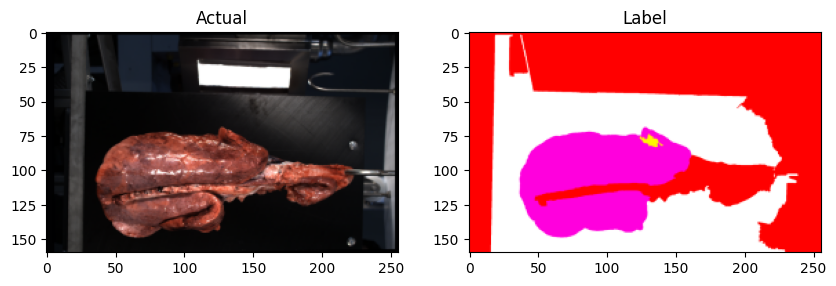

In [204]:
data_iter = iter(train_loader)
img, lab = next(data_iter)

show([img[0], lab[0]])
print(img[0].shape)


In [205]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [206]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [207]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.conv(x) #for skip connection feature map to decoder
        p = self.pool(x)
        return x, p

In [208]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.convT =  nn.ConvTranspose2d(in_c, out_c, kernel_size = 2, padding = 0, stride = 2)
        self.conv = conv_block(2*out_c, out_c)

    def forward(self, inputs, skips):
        x = self.convT(inputs)
        x = torch.cat([x, skips], axis = 1)
        x = self.conv(x)
        return x

In [209]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        """"Encoder part"""

        self.en1 = encoder_block(3, 64)
        self.en2 = encoder_block(64, 128)
        self.en3 = encoder_block(128, 256)
        self.en4 = encoder_block(256, 512)

        """Bottleneck"""

        self.b = conv_block(512, 1024)


        """decoder part"""

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)


        """Classifier"""
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, input):
#         print(input.shape)
        s1, p1 = self.en1(input)
        s2, p2 = self.en2(p1)
        s3, p3 = self.en3(p2)
        s4, p4 = self.en4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        out = self.outputs(d4)

        return out

In [210]:
model = Unet().float().to(device)

epochs = 30

lr = 0.01

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [211]:
train_loss = []
val_loss = []

100%|██████████| 10/10 [00:00<00:00, 50.05it/s]


epoch : 9 ,train loss : 0.5732033997774124 ,valid loss : 0.19600697606801987 


100%|██████████| 10/10 [00:00<00:00, 41.42it/s]


epoch : 9 ,train loss : 0.1980310045182705 ,valid loss : 0.17349196523427962 


100%|██████████| 10/10 [00:00<00:00, 44.64it/s]


epoch : 9 ,train loss : 0.14941325597465038 ,valid loss : 0.1334853857755661 


100%|██████████| 10/10 [00:00<00:00, 47.54it/s]


epoch : 9 ,train loss : 0.13110092282295227 ,valid loss : 0.12324587181210518 


100%|██████████| 10/10 [00:00<00:00, 48.51it/s]


epoch : 9 ,train loss : 0.10420837253332138 ,valid loss : 0.11862808763980866 


100%|██████████| 10/10 [00:00<00:00, 48.68it/s]


epoch : 9 ,train loss : 0.09965137857943773 ,valid loss : 0.11008517891168594 


100%|██████████| 10/10 [00:00<00:00, 50.18it/s]


epoch : 9 ,train loss : 0.09647596068680286 ,valid loss : 0.11051438301801682 


100%|██████████| 10/10 [00:00<00:00, 43.54it/s]


epoch : 9 ,train loss : 0.09488326869904995 ,valid loss : 0.10732666775584221 


100%|██████████| 10/10 [00:00<00:00, 41.82it/s]


epoch : 9 ,train loss : 0.09522771276533604 ,valid loss : 0.10705877020955086 


100%|██████████| 10/10 [00:00<00:00, 47.75it/s]


epoch : 9 ,train loss : 0.09846379235386848 ,valid loss : 0.10527426972985268 


100%|██████████| 10/10 [00:00<00:00, 46.47it/s]


epoch : 9 ,train loss : 0.08823075797408819 ,valid loss : 0.10458825826644898 


100%|██████████| 10/10 [00:00<00:00, 46.69it/s]


epoch : 9 ,train loss : 0.09371836297214031 ,valid loss : 0.09911751635372638 


100%|██████████| 10/10 [00:00<00:00, 44.48it/s]


epoch : 9 ,train loss : 0.09078024048358202 ,valid loss : 0.09894410073757172 


100%|██████████| 10/10 [00:00<00:00, 46.13it/s]


epoch : 9 ,train loss : 0.08997535426169634 ,valid loss : 0.10033218860626221 


100%|██████████| 10/10 [00:00<00:00, 42.17it/s]


epoch : 9 ,train loss : 0.08825287409126759 ,valid loss : 0.10015125572681427 


100%|██████████| 10/10 [00:00<00:00, 40.45it/s]


epoch : 9 ,train loss : 0.09259963966906071 ,valid loss : 0.09944231137633323 


100%|██████████| 10/10 [00:00<00:00, 49.75it/s]


epoch : 9 ,train loss : 0.08830144722014666 ,valid loss : 0.10446922704577447 


100%|██████████| 10/10 [00:00<00:00, 47.55it/s]


epoch : 9 ,train loss : 0.08906113728880882 ,valid loss : 0.09703885428607464 


100%|██████████| 10/10 [00:00<00:00, 47.95it/s]


epoch : 9 ,train loss : 0.08073488809168339 ,valid loss : 0.09969135709106922 


100%|██████████| 10/10 [00:00<00:00, 48.60it/s]


epoch : 9 ,train loss : 0.0842068362981081 ,valid loss : 0.0983988918364048 


100%|██████████| 10/10 [00:00<00:00, 41.91it/s]


epoch : 9 ,train loss : 0.08825364615768194 ,valid loss : 0.09859728813171387 


100%|██████████| 10/10 [00:00<00:00, 41.65it/s]


epoch : 9 ,train loss : 0.08231852389872074 ,valid loss : 0.09580655172467231 


100%|██████████| 10/10 [00:00<00:00, 43.33it/s]


epoch : 9 ,train loss : 0.08625079784542322 ,valid loss : 0.09203572645783424 


100%|██████████| 10/10 [00:00<00:00, 46.50it/s]


epoch : 9 ,train loss : 0.08733505103737116 ,valid loss : 0.10013138018548488 


100%|██████████| 10/10 [00:00<00:00, 47.72it/s]


epoch : 9 ,train loss : 0.08395169395953417 ,valid loss : 0.09665660820901394 


100%|██████████| 10/10 [00:00<00:00, 48.41it/s]


epoch : 9 ,train loss : 0.08130939025431871 ,valid loss : 0.09615439809858799 


100%|██████████| 10/10 [00:00<00:00, 47.34it/s]


epoch : 9 ,train loss : 0.08545163087546825 ,valid loss : 0.10337919592857361 


100%|██████████| 10/10 [00:00<00:00, 42.46it/s]


epoch : 9 ,train loss : 0.0871935486793518 ,valid loss : 0.09456525184214115 


100%|██████████| 10/10 [00:00<00:00, 44.15it/s]


epoch : 9 ,train loss : 0.08801557496190071 ,valid loss : 0.10054410025477409 


100%|██████████| 10/10 [00:00<00:00, 47.35it/s]


epoch : 9 ,train loss : 0.08002904895693064 ,valid loss : 0.09738686233758927 


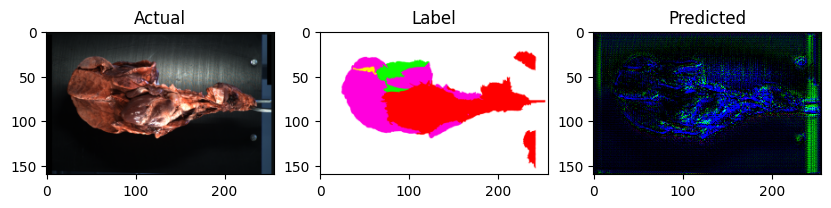

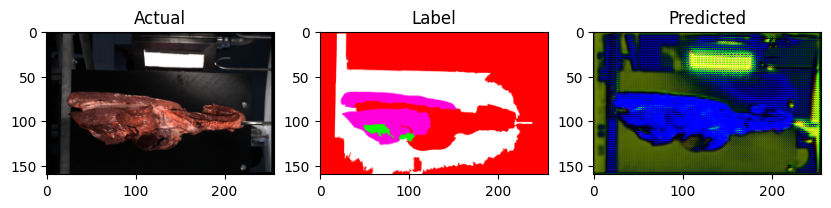

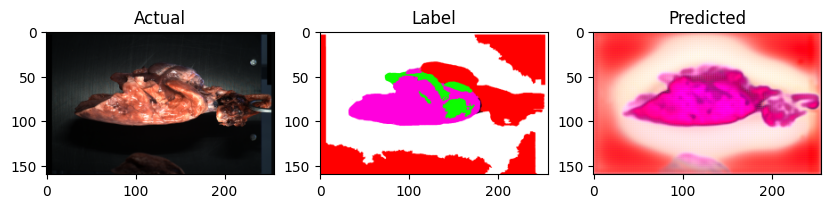

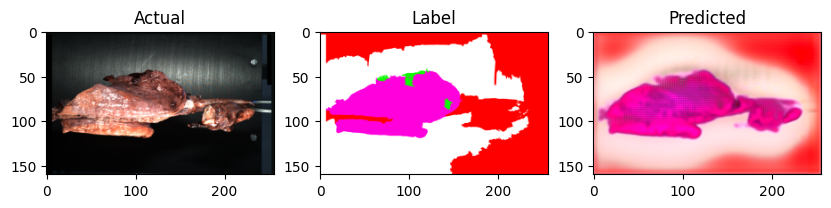

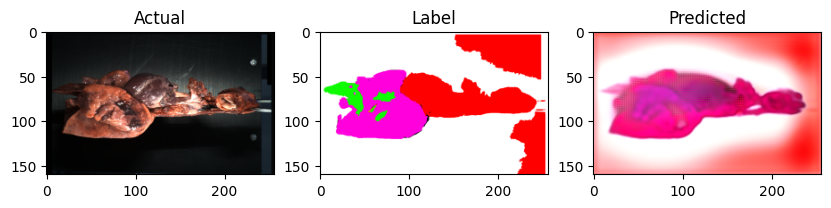

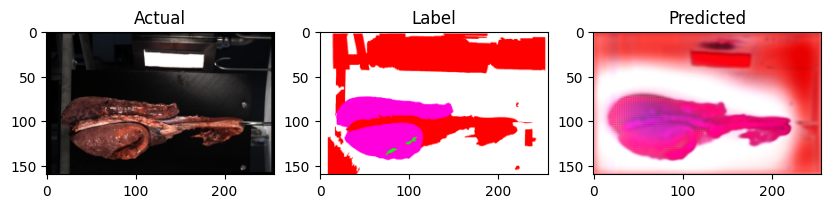

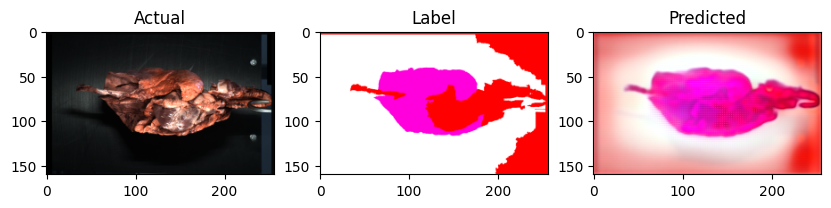

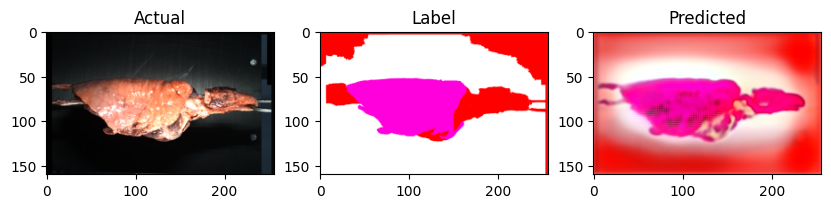

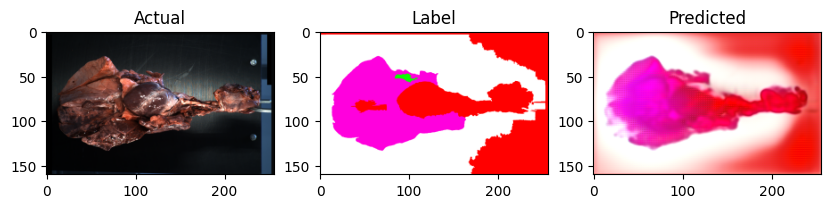

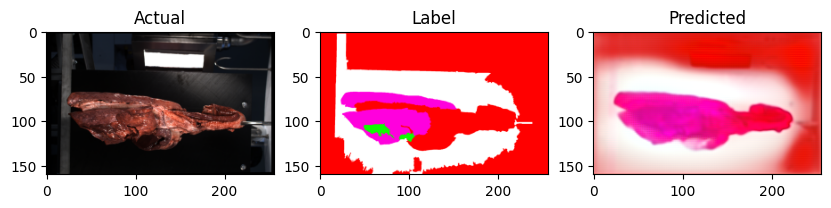

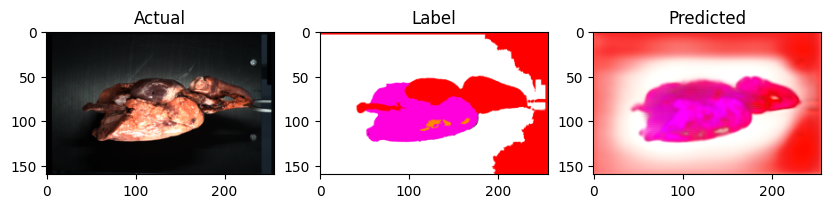

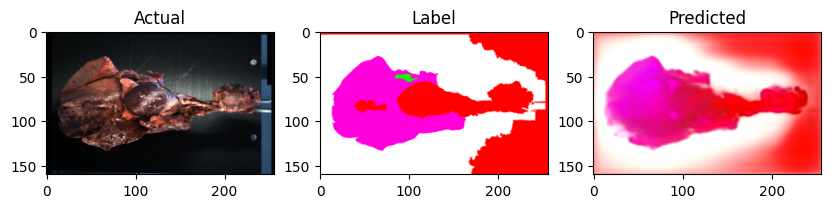

In [212]:
# model.to(device)
for epoch in range(epochs):
    trainloss = 0
    valloss = 0
    c = 0
    for img, lab in tqdm(train_loader):
        optimizer.zero_grad()
        img = img.to(device)
        lab = lab.to(device)
        output = model(img)
        loss = loss_func(output, lab)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()


        if epoch % 5 == 0 and c < 2:
            show([img[0], lab[0], output[0]])
            c += 1
    train_loss.append(trainloss/len(train_loader))



    for img, lab in tqdm(valid_loader):
        img = img.to(device)
        lab = lab.to(device)
        output = model(img)
        loss = loss_func(output, lab)
        valloss += loss.item()
    val_loss.append(valloss/len(valid_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

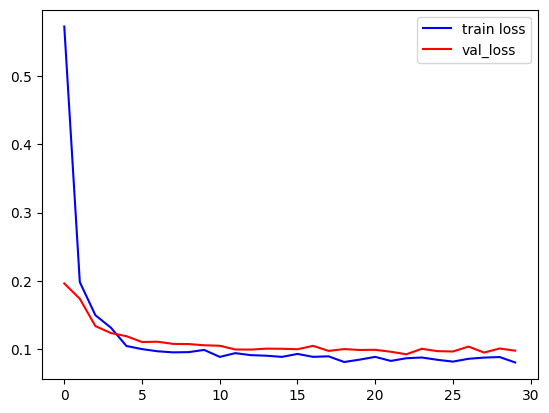

In [213]:
plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()

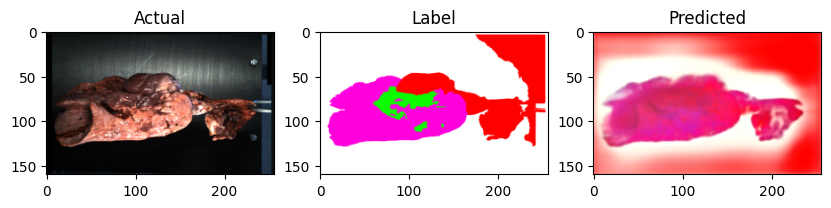

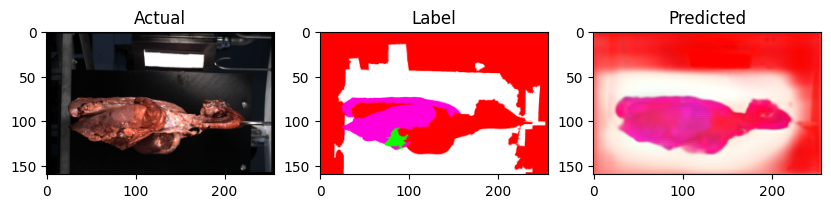

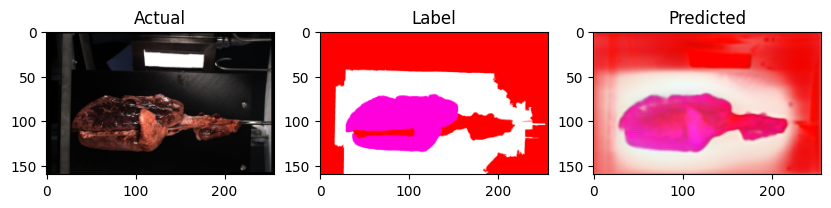

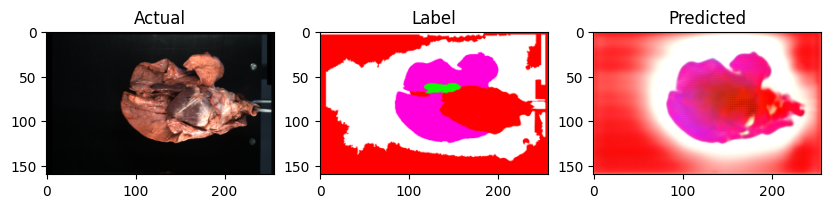

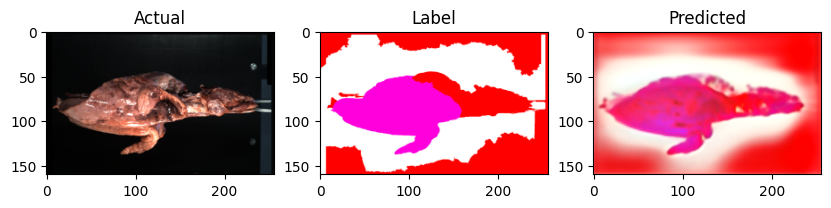

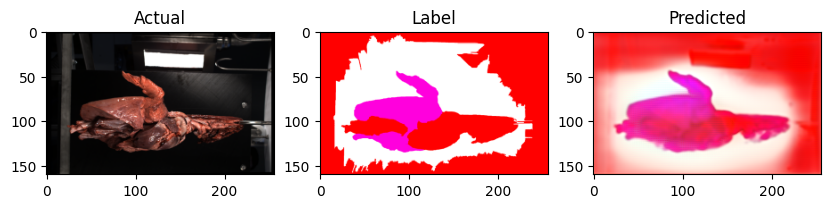

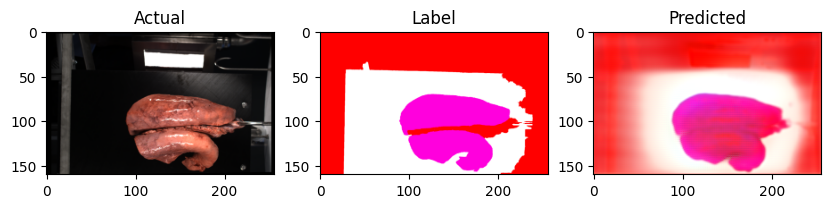

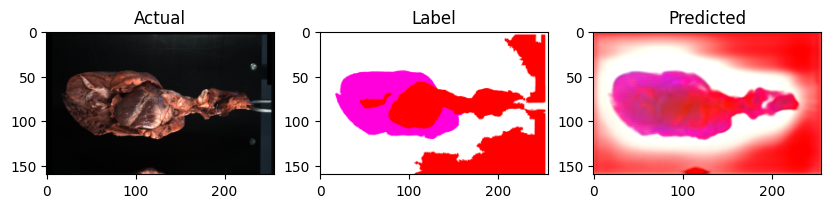

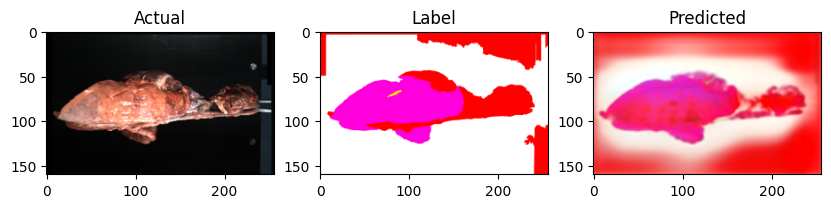

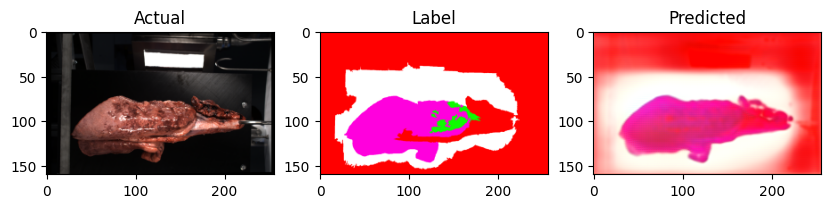

In [214]:
c = 0
for img, lab in valid_loader:
    img = img.to(device)
    label = lab.to(device)
    output = model(img)
    show([img[0],label[0],output[0]])
    if c>20:
        break
    c+=1